<a href="https://colab.research.google.com/github/cmb170230/Portfolio/blob/main/Image%20Classification%20using%20Convolutional%20Neural%20Networks/FormulaOne_Classification_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d vesuvius13/formula-one-cars
! unzip -q formula-one-cars.zip

100% 780M/782M [00:38<00:00, 20.9MB/s]
100% 782M/782M [00:38<00:00, 21.0MB/s]


In [ ]:
import os
import imghdr

# Not all the data is formatted correctly, so go through each folder and delete
# images that are not jpegs
for folder in os.listdir('/content/Formula One Cars'):
  for filename in os.listdir('/content/Formula One Cars/{}'.format(folder)):
    extension = imghdr.what('/content/Formula One Cars/{}/{}'.format(folder, filename))

    if (extension != 'jpeg'):
      try:
        os.remove('/content/Formula One Cars/{}/{}'.format(folder, filename))
      except:
        dummy = 'yep this except does nothing'

In [ ]:
batch_sz = 64

# Get training and validation partitions of the data
trainds = keras.utils.image_dataset_from_directory("/content/Formula One Cars", image_size = (224, 224), 
                                              batch_size = batch_sz, shuffle = True, seed = 101,
                                              validation_split = 0.1, subset = 'training',
                                              label_mode = 'categorical')
val_and_testds = keras.utils.image_dataset_from_directory("/content/Formula One Cars", image_size = (224, 224), 
                                              batch_size = batch_sz, shuffle = True, seed = 101, 
                                              label_mode = 'categorical', validation_split = 0.1,
                                              subset = 'validation')

Found 1905 files belonging to 8 classes.
Using 1715 files for training.
Found 1905 files belonging to 8 classes.
Using 190 files for validation.


In [ ]:
# Split into validation and test datasets
validationds = val_and_testds.take(round(2/3 * 190))
testds = val_and_testds.skip(round(2/3 * 190))

In [ ]:
display_ds = keras.utils.image_dataset_from_directory("/content/Formula One Cars", image_size = (224, 224), 
                                              batch_size = batch_sz, shuffle = True, seed = 101)

Found 1905 files belonging to 8 classes.


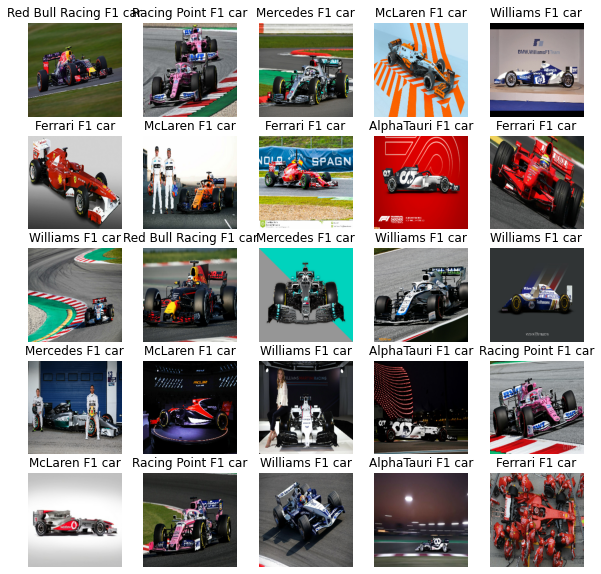

In [ ]:
class_names = display_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in display_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

trainds = trainds.prefetch(buffer_size = AUTOTUNE)
validationds = validationds.prefetch(buffer_size = AUTOTUNE)
testds = testds.prefetch(buffer_size = AUTOTUNE)

In [ ]:
transfer_layer = keras.applications.MobileNetV2(input_shape = (224, 224, 3), 
                                                weights = 'imagenet', include_top = False, pooling = 'max')
transfer_layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


We attempt all our experiments using two different convolutional bases, first MobileNetV2 trained on ImageNet, and second with ResNetV2 trained on ImageNet.

# Iteration A.1 - Starting Model

In [ ]:
model = keras.Sequential([
    keras.layers.Rescaling(1. / 127.5, offset = -1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    transfer_layer,
    keras.layers.Dense(512, activation = 'relu', name = 'hidden_layer2'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation = 'relu', name = 'hidden_layer3'),
    keras.layers.Dense(8, activation = 'softmax', name = 'output')
   ])

model.build(input_shape = (None, 224, 224, 3))
model.summary()

base_learning_rate = 0.0001
model.compile(optimizer = keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 hidden_layer2 (Dense)       (None, 512)               6

In [ ]:
history = model.fit(trainds, epochs = 20, validation_data = validationds)

Epoch 1/20
27/27 [==============================] - 37s 795ms/step - loss: 3.5323 - accuracy: 0.1738 - val_loss: 2.5312 - val_accuracy: 0.2000
Epoch 2/20
27/27 [==============================] - 27s 792ms/step - loss: 2.1308 - accuracy: 0.2898 - val_loss: 1.9384 - val_accuracy: 0.3684
Epoch 3/20
27/27 [==============================] - 27s 783ms/step - loss: 1.8302 - accuracy: 0.3755 - val_loss: 1.6780 - val_accuracy: 0.4105
Epoch 4/20
27/27 [==============================] - 27s 783ms/step - loss: 1.5974 - accuracy: 0.4461 - val_loss: 1.4988 - val_accuracy: 0.4842
Epoch 5/20
27/27 [==============================] - 27s 791ms/step - loss: 1.4497 - accuracy: 0.4997 - val_loss: 1.4110 - val_accuracy: 0.5053
Epoch 6/20
27/27 [==============================] - 27s 782ms/step - loss: 1.3035 - accuracy: 0.5388 - val_loss: 1.2956 - val_accuracy: 0.5526
Epoch 7/20
27/27 [==============================] - 27s 760ms/step - loss: 1.2020 - accuracy: 0.5668 - val_loss: 1.2373 - val_accuracy: 0.5684

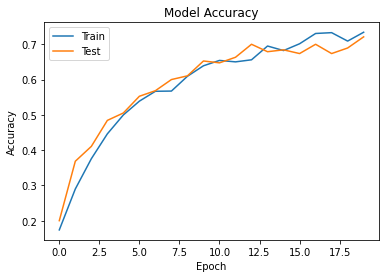

---------------------------------------------------------------------


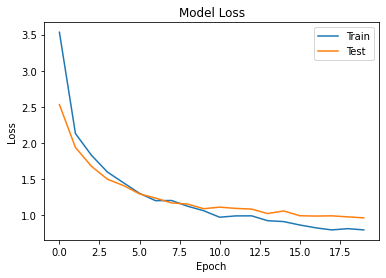

---------------------------------------------------------------------


In [ ]:
  # Print plots
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

# Iteration A.2 - Tuning Learning Rate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 hidden_layer2 (Dense)       (None, 512)               6

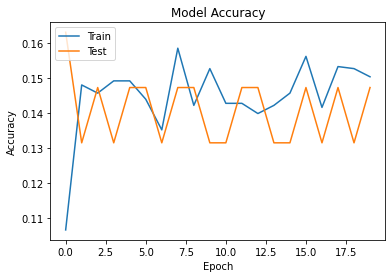

---------------------------------------------------------------------


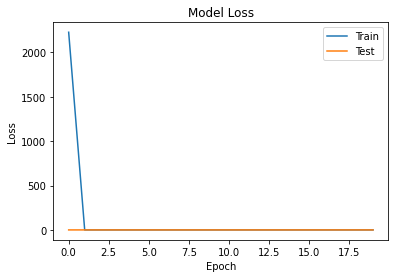

---------------------------------------------------------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

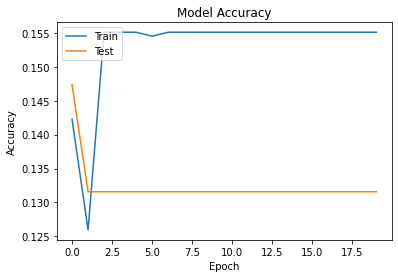

---------------------------------------------------------------------


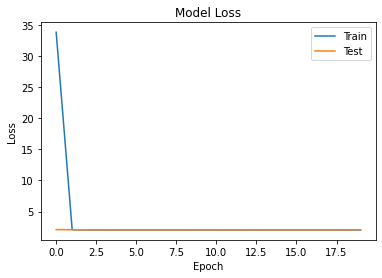

---------------------------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

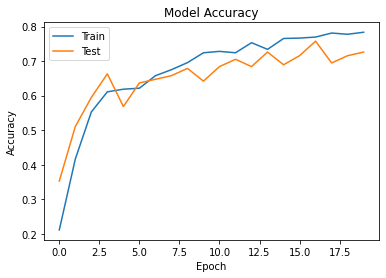

---------------------------------------------------------------------


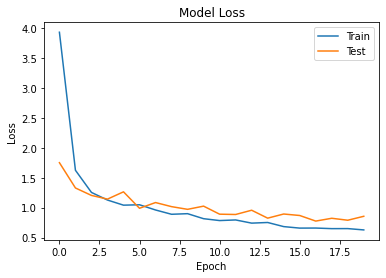

---------------------------------------------------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

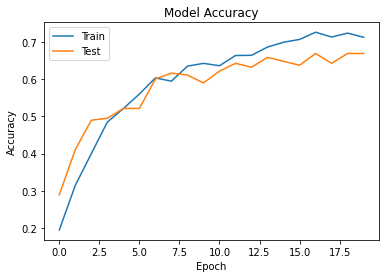

---------------------------------------------------------------------


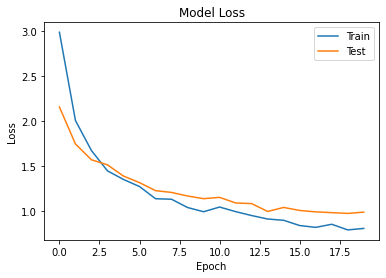

---------------------------------------------------------------------


In [ ]:
# Tune learning rate
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for rate in learning_rates:
  model = keras.Sequential([
    keras.layers.Rescaling(1. / 127.5, offset = -1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    transfer_layer,
    keras.layers.Dense(512, activation = 'relu', name = 'hidden_layer2'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation = 'relu', name = 'hidden_layer3'),
    keras.layers.Dense(8, activation = 'softmax', name = 'output')
   ])

  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

  history = model.fit(trainds, epochs = 20, validation_data = validationds)
  
  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

In [ ]:
optimal_rate = 0.001

Best is learning rate of 0.001

# Iteration A.3 - Tuning Activation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 hidden_layer2 (Dense)       (None, 512)               6

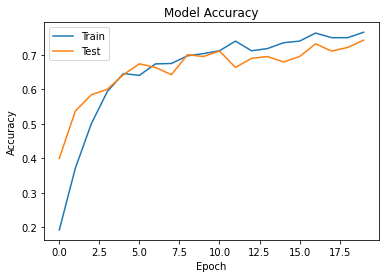

---------------------------------------------------------------------


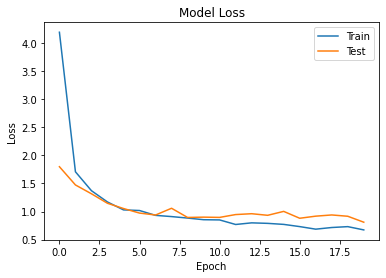

---------------------------------------------------------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

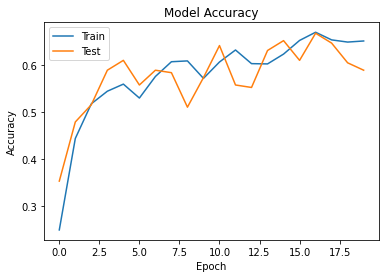

---------------------------------------------------------------------


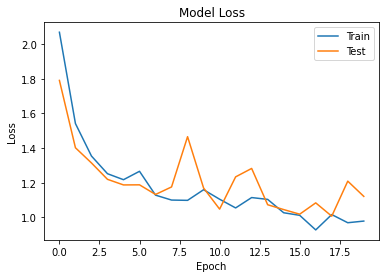

---------------------------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

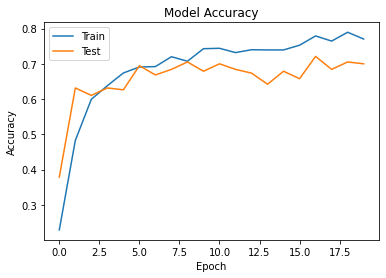

---------------------------------------------------------------------


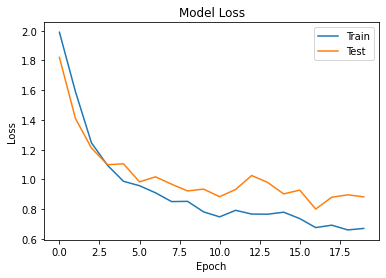

---------------------------------------------------------------------


In [ ]:
# Tune activation function
activation_functions = ['relu', 'tanh', 'sigmoid']

for activation_function in activation_functions: 
  model = keras.Sequential([
    keras.layers.Rescaling(1. / 127.5, offset = -1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    transfer_layer,
    keras.layers.Dense(512, activation = activation_function, name = 'hidden_layer2'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation = activation_function, name = 'hidden_layer3'),
    keras.layers.Dense(8, activation = 'softmax', name = 'output')
   ])
  
  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

  history = model.fit(trainds, epochs = 20, validation_data = validationds)
  
  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

In [ ]:
optimal_activation = 'relu'

Best is relu activation function

# Iteration A.4 - Tuning \# of Neurons for One Dense Layer with no Dropout

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_5 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 hidden_layer2 (Dense)       (None, 128)              

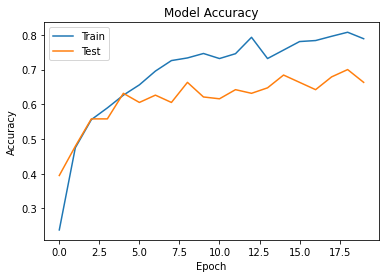

---------------------------------------------------------------------


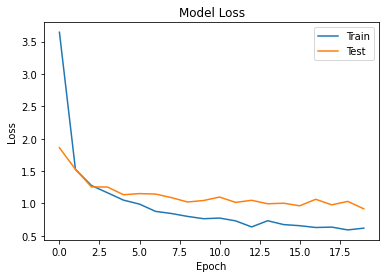

---------------------------------------------------------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

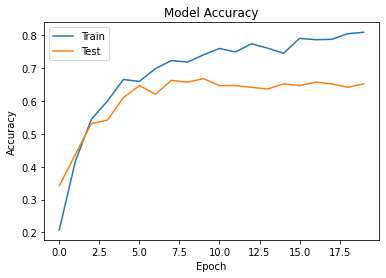

---------------------------------------------------------------------


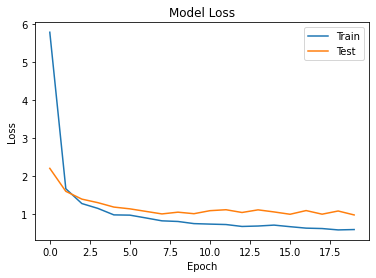

---------------------------------------------------------------------
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_7 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_7 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

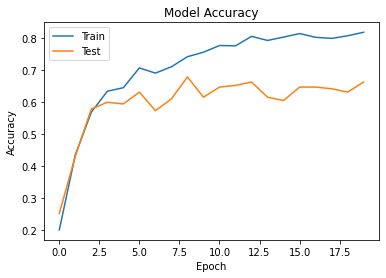

---------------------------------------------------------------------


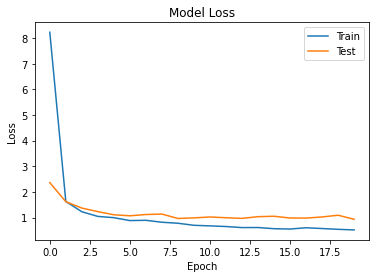

---------------------------------------------------------------------
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_8 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

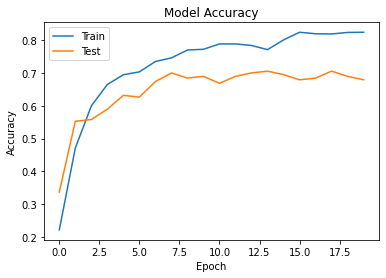

---------------------------------------------------------------------


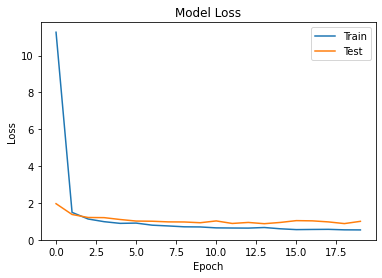

---------------------------------------------------------------------


In [ ]:
# Tune number of neurons
numNeurons = [128, 256, 512, 1024]

for neurons in numNeurons:  
  model = keras.Sequential([
      keras.layers.Rescaling(1. / 127.5, offset = -1),
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.2),
      transfer_layer,
      keras.layers.Dense(neurons, activation = optimal_activation, name = 'hidden_layer2'),
      keras.layers.Dense(8, activation = 'softmax', name = 'output')
    ])
  
  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
  
  history = model.fit(trainds, epochs = 20, validation_data = validationds)
  
  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

# Iteration A.5 - Tuning \# of Neurons for Two Dense Layers with no Dropout

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_11 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_11 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_11 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 hidden_layer2 (Dense)       (None, 128)             

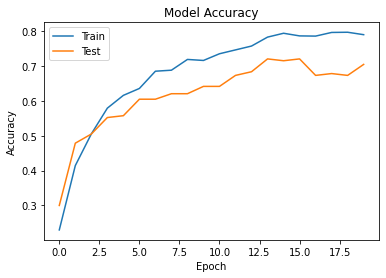

---------------------------------------------------------------------


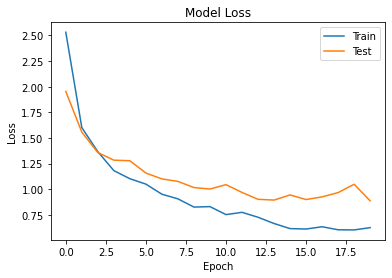

---------------------------------------------------------------------
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_12 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_12 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_12 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                 

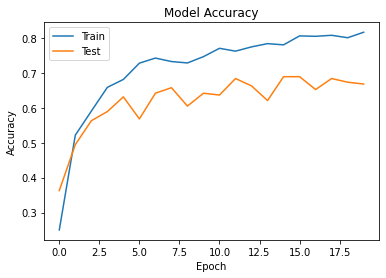

---------------------------------------------------------------------


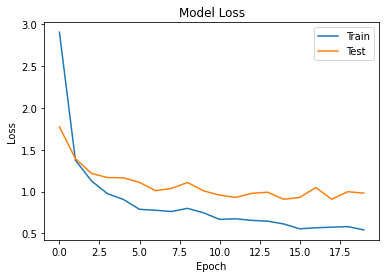

---------------------------------------------------------------------
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_13 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_13 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_13 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                 

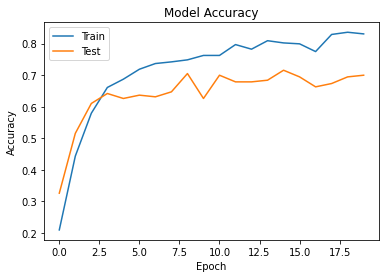

---------------------------------------------------------------------


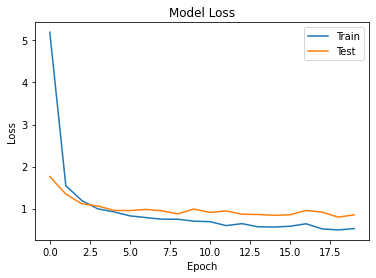

---------------------------------------------------------------------
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_14 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_14 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_14 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                 

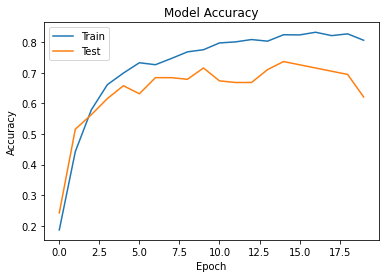

---------------------------------------------------------------------


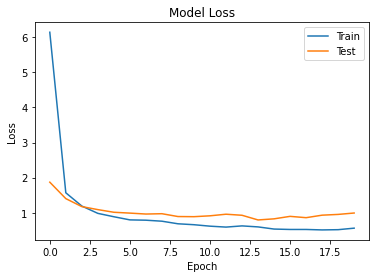

---------------------------------------------------------------------


In [ ]:
# Tune number of neurons
numNeurons = [128, 256, 512, 1024]

for neurons in numNeurons:  
  model = keras.Sequential([
      keras.layers.Rescaling(1. / 127.5, offset = -1),
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.2),
      transfer_layer,
      keras.layers.Dense(neurons, activation = optimal_activation, name = 'hidden_layer2'),
      keras.layers.Dense(neurons / 2, activation = optimal_activation, name = 'hidden_layer3'),
      keras.layers.Dense(8, activation = 'softmax', name = 'output')
    ])
  
  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
  
  history = model.fit(trainds, epochs = 20, validation_data = validationds)
  
  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

In [ ]:
optimal_neurons = 1024

Best is two dense layers with 1024 and 512 number of neurons

# Iteration A.6 - Tuning Dropout Value with Two Dense Layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 hidden_layer (Dense)        (None, 1024)              1

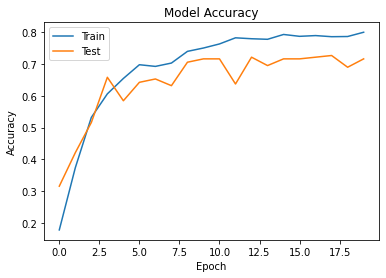

---------------------------------------------------------------------


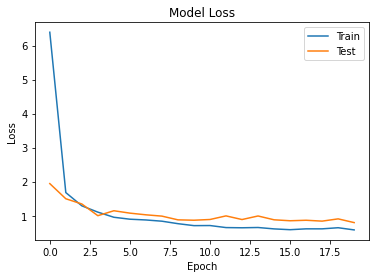

---------------------------------------------------------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

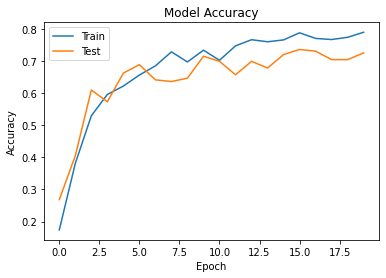

---------------------------------------------------------------------


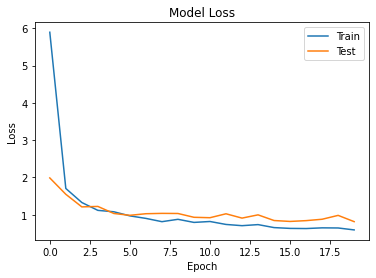

---------------------------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

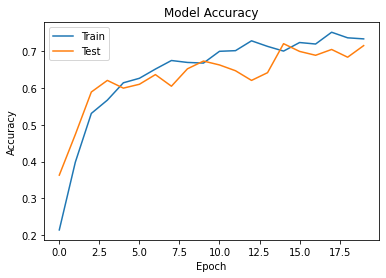

---------------------------------------------------------------------


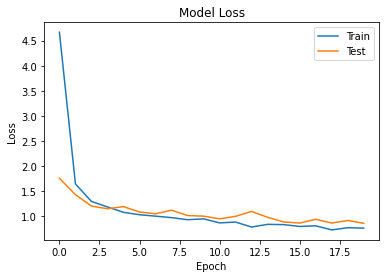

---------------------------------------------------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                  

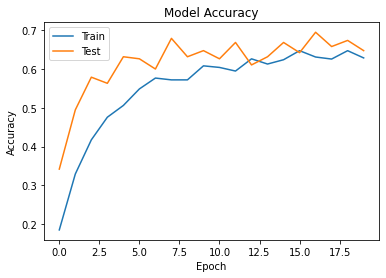

---------------------------------------------------------------------


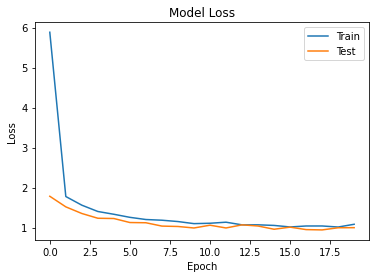

---------------------------------------------------------------------


In [ ]:
# Tune dropout value
dropout_values = [0.1, 0.2, 0.33, 0.5]

for value in dropout_values:  
  model = keras.Sequential([
      keras.layers.Rescaling(1./127.5, offset = -1),
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.2),
      transfer_layer,
      keras.layers.Dense(optimal_neurons, activation = optimal_activation, name = 'hidden_layer'),
      keras.layers.Dropout(value),
      keras.layers.Dense(optimal_neurons / 2, activation = optimal_activation, name = 'hidden_layer2'),
      keras.layers.Dense(8, activation = 'softmax', name = 'output')
    ])
  
  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
  
  history = model.fit(trainds, epochs = 20, validation_data = validationds)

  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

In [ ]:
optimal_dropout = 0.2

Best is dropout rate of 0.2

# Iteration A.7 - Fine Tuning Using Optimal Hyperparameters

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_5 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 hidden_layer (Dense)        (None, 1024)             

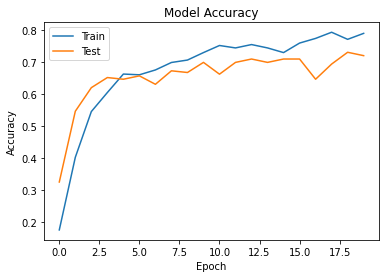

---------------------------------------------------------------------


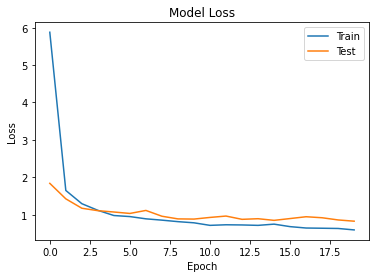

---------------------------------------------------------------------


In [ ]:
# Fit model with all optimal hyperparameters and convolutional base frozen
model = keras.Sequential([ 
    keras.layers.Rescaling(1. / 127.5, offset = -1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    transfer_layer,
    keras.layers.Dense(optimal_neurons, activation = optimal_activation, name = 'hidden_layer'),
    keras.layers.Dropout(optimal_dropout),
    keras.layers.Dense(optimal_neurons / 2, activation = optimal_activation, name = 'hidden_layer2'),
    keras.layers.Dense(8, activation = 'softmax', name = 'output')
    ])
  
model.build(input_shape = (None, 224, 224, 3))
model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
  
history = model.fit(trainds, epochs = 20, validation_data = validationds)

# Print plots
print('---------------------------------------------------------------------')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()
print('---------------------------------------------------------------------')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()
print('---------------------------------------------------------------------')

In [ ]:
# Unfreeze convolutional base
transfer_layer.trainable = True

# Refreeze first 15 blocks of convolutional base
for layer in transfer_layer.layers[:-12]:
  layer.trainable = False

# Batch normalization layers should remain frozen
transfer_layer.layers[-3].trainable = False
transfer_layer.layers[-5].trainable = False
transfer_layer.layers[-8].trainable = False
transfer_layer.layers[-11].trainable = False

Epoch 1/10
27/27 [==============================] - 27s 775ms/step - loss: 0.5578 - accuracy: 0.8064 - val_loss: 0.9237 - val_accuracy: 0.6632
Epoch 2/10
27/27 [==============================] - 26s 731ms/step - loss: 0.6018 - accuracy: 0.7878 - val_loss: 0.8785 - val_accuracy: 0.7105
Epoch 3/10
27/27 [==============================] - 27s 769ms/step - loss: 0.5982 - accuracy: 0.7965 - val_loss: 0.9496 - val_accuracy: 0.6842
Epoch 4/10
27/27 [==============================] - 27s 730ms/step - loss: 0.6318 - accuracy: 0.7895 - val_loss: 0.9406 - val_accuracy: 0.6895
Epoch 5/10
27/27 [==============================] - 27s 768ms/step - loss: 0.5726 - accuracy: 0.8006 - val_loss: 0.8706 - val_accuracy: 0.7105
Epoch 6/10
27/27 [==============================] - 26s 731ms/step - loss: 0.5658 - accuracy: 0.8052 - val_loss: 0.9359 - val_accuracy: 0.6684
Epoch 7/10
27/27 [==============================] - 27s 796ms/step - loss: 0.5272 - accuracy: 0.8152 - val_loss: 0.8878 - val_accuracy: 0.6684

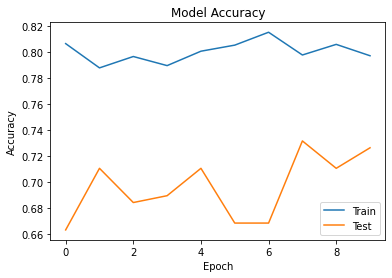

---------------------------------------------------------------------


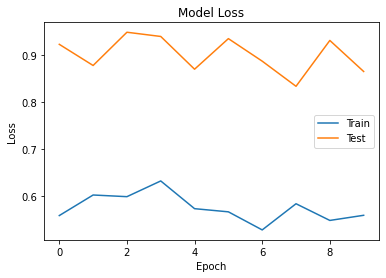

---------------------------------------------------------------------


In [ ]:
# Fine tune for fewer epochs since the model has already been fit for 20 epochs
history = model.fit(trainds, epochs = 10, validation_data = validationds)

# Print plots
print('---------------------------------------------------------------------')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()
print('---------------------------------------------------------------------')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()
print('---------------------------------------------------------------------')

# Iteration B.1 - Starting Model

In [ ]:
import tensorflow_hub as hub
transfer_layer2 = hub.KerasLayer('https://tfhub.dev/sayakpaul/distill_bit_r50x1_224_feature_extraction/1', input_shape = (224,224,3))

In [ ]:
transfer_layer2.trainable = False

In [ ]:
# Batch size of 64 was too large for second model and resulted in ResourceExhaustedError, so reduce batch size
batch_sz = 32

# Get training and validation partitions of the data
trainds = keras.utils.image_dataset_from_directory("/content/Formula One Cars", image_size = (224, 224), 
                                              batch_size = batch_sz, shuffle = True, seed = 101,
                                              validation_split = 0.1, subset = 'training',
                                              label_mode = 'categorical')
val_and_testds = keras.utils.image_dataset_from_directory("/content/Formula One Cars", image_size = (224, 224), 
                                              batch_size = batch_sz, shuffle = True, seed = 101, 
                                              label_mode = 'categorical', validation_split = 0.1,
                                              subset = 'validation')

Found 1905 files belonging to 8 classes.
Using 1715 files for training.
Found 1905 files belonging to 8 classes.
Using 190 files for validation.


In [ ]:
# Split into validation and test datasets
validationds = val_and_testds.take(round(2/3 * 190))
testds = val_and_testds.skip(round(2/3 * 190))

In [ ]:
model = keras.Sequential([
    keras.layers.Rescaling(1. / 127.5, offset = -1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    transfer_layer2,
    keras.layers.Dense(512, activation = 'relu', name = 'hidden_layer2'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation = 'relu', name = 'hidden_layer3'),
    keras.layers.Dense(8, activation = 'softmax', name = 'output')
   ])

model.build(input_shape = (None, 224, 224, 3))
model.summary()

base_learning_rate = 0.0001
model.compile(optimizer = keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_8 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)               1049088   
                                                      

In [ ]:
history = model.fit(trainds, epochs = 10, validation_data = validationds)

Epoch 1/10
54/54 [==============================] - 48s 840ms/step - loss: 1.9913 - accuracy: 0.2192 - val_loss: 1.8991 - val_accuracy: 0.3947
Epoch 2/10
54/54 [==============================] - 49s 849ms/step - loss: 1.7720 - accuracy: 0.4536 - val_loss: 1.6940 - val_accuracy: 0.4789
Epoch 3/10
54/54 [==============================] - 49s 856ms/step - loss: 1.4711 - accuracy: 0.5913 - val_loss: 1.3989 - val_accuracy: 0.6526
Epoch 4/10
54/54 [==============================] - 49s 856ms/step - loss: 1.2074 - accuracy: 0.6834 - val_loss: 1.1249 - val_accuracy: 0.7474
Epoch 5/10
54/54 [==============================] - 49s 853ms/step - loss: 1.0183 - accuracy: 0.7300 - val_loss: 1.0421 - val_accuracy: 0.7158
Epoch 6/10
54/54 [==============================] - 49s 855ms/step - loss: 0.8990 - accuracy: 0.7528 - val_loss: 0.9278 - val_accuracy: 0.7158
Epoch 7/10
54/54 [==============================] - 49s 845ms/step - loss: 0.8028 - accuracy: 0.7668 - val_loss: 0.8163 - val_accuracy: 0.7632

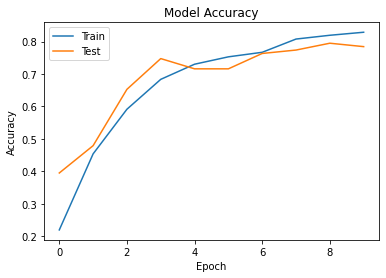

---------------------------------------------------------------------


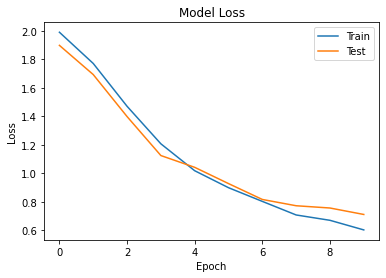

---------------------------------------------------------------------


In [ ]:
# Print plots
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('---------------------------------------------------------------------')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()
print('---------------------------------------------------------------------')

# Iteration B.2 - Tuning Learning Rate

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)               1049088   
                                                      

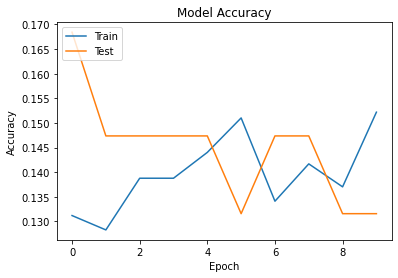

---------------------------------------------------------------------


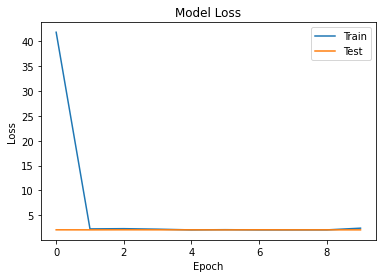

---------------------------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)          

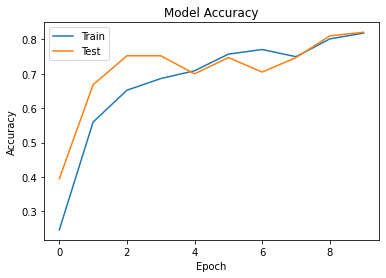

---------------------------------------------------------------------


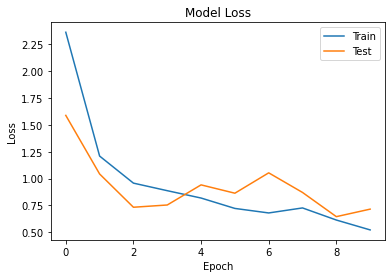

---------------------------------------------------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)          

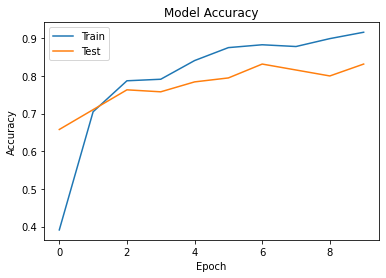

---------------------------------------------------------------------


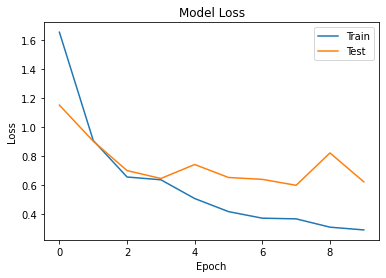

---------------------------------------------------------------------
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)          

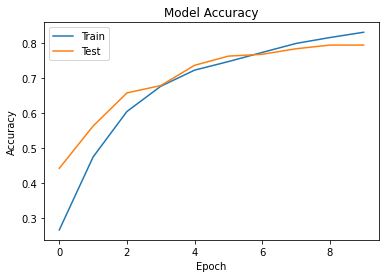

---------------------------------------------------------------------


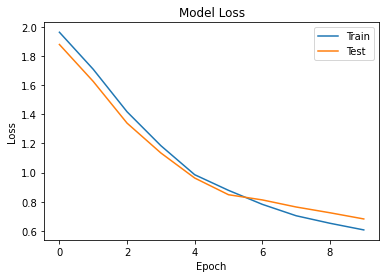

---------------------------------------------------------------------


In [ ]:
# Tune learning rate
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for rate in learning_rates:
  model = keras.Sequential([
    keras.layers.Rescaling(1. / 127.5, offset = -1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    transfer_layer2,
    keras.layers.Dense(512, activation = 'relu', name = 'hidden_layer2'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation = 'relu', name = 'hidden_layer3'),
    keras.layers.Dense(8, activation = 'softmax', name = 'output')
   ])

  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

  history = model.fit(trainds, epochs = 10, validation_data = validationds)
  
  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

In [ ]:
optimal_rate = 0.001

Best is learning rate of 0.001

# Iteration B.3 - Tuning Activation Function

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_5 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)               1049088   
                                                      

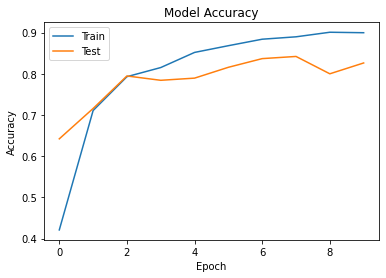

---------------------------------------------------------------------


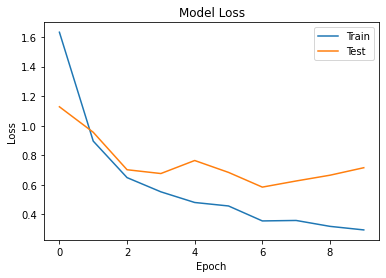

---------------------------------------------------------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)          

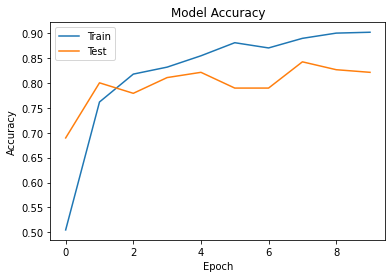

---------------------------------------------------------------------


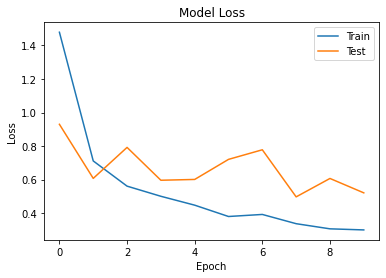

---------------------------------------------------------------------
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_7 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_7 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)          

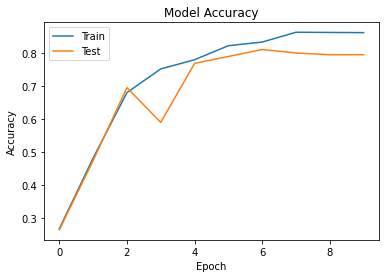

---------------------------------------------------------------------


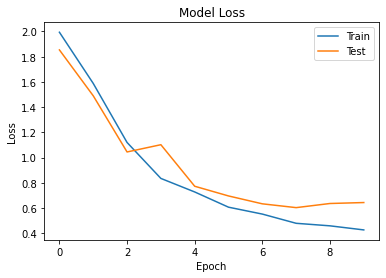

---------------------------------------------------------------------


In [ ]:
# Tune activation function
activation_functions = ['relu', 'tanh', 'sigmoid']

for activation_function in activation_functions: 
  model = keras.Sequential([
    keras.layers.Rescaling(1. / 127.5, offset = -1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    transfer_layer2,
    keras.layers.Dense(512, activation = activation_function, name = 'hidden_layer2'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation = activation_function, name = 'hidden_layer3'),
    keras.layers.Dense(8, activation = 'softmax', name = 'output')
   ])
  
  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

  history = model.fit(trainds, epochs = 10, validation_data = validationds)
  
  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

In [ ]:
optimal_activation = 'relu'

Best is relu activation function

# Iteration B.4 - Tuning \# of Neurons for One Dense Layer with no Dropout

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_8 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 128)               262272    
                                                      

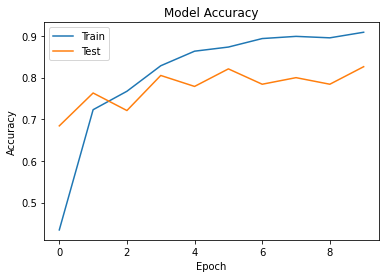

---------------------------------------------------------------------


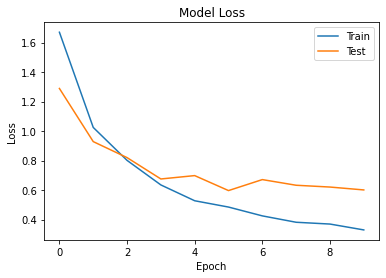

---------------------------------------------------------------------
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_9 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_9 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_9 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 256)          

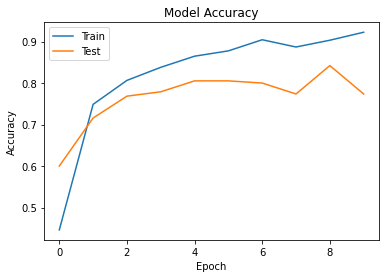

---------------------------------------------------------------------


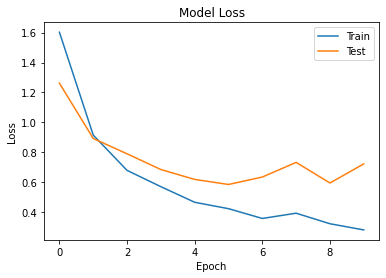

---------------------------------------------------------------------
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_10 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_10 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_10 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)         

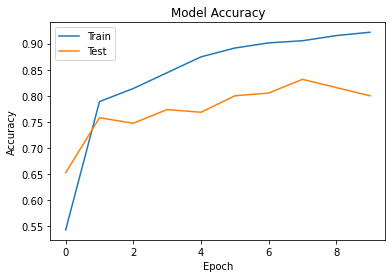

---------------------------------------------------------------------


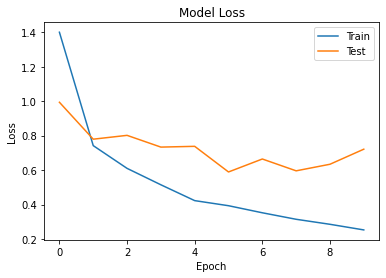

---------------------------------------------------------------------
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_11 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_11 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_11 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 1024)        

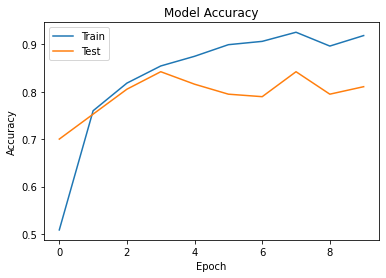

---------------------------------------------------------------------


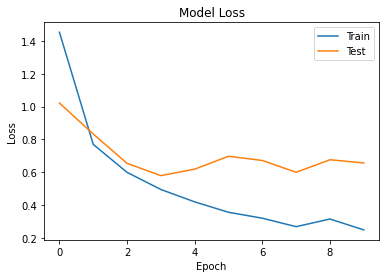

---------------------------------------------------------------------


In [ ]:
# Tune number of neurons
numNeurons = [128, 256, 512, 1024]

for neurons in numNeurons:  
  model = keras.Sequential([
      keras.layers.Rescaling(1. / 127.5, offset = -1),
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.2),
      transfer_layer2,
      keras.layers.Dense(neurons, activation = optimal_activation, name = 'hidden_layer2'),
      keras.layers.Dense(8, activation = 'softmax', name = 'output')
    ])
  
  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
  
  history = model.fit(trainds, epochs = 10, validation_data = validationds)
  
  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

# Iteration B.5 - Tuning \# of Neurons for Two Dense Layers with no Dropout

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_12 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_12 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_12 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 128)               262272    
                                                     

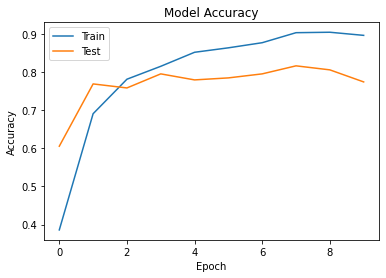

---------------------------------------------------------------------


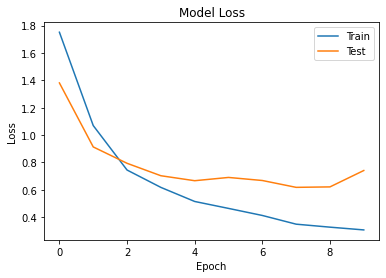

---------------------------------------------------------------------
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_13 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_13 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_13 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 256)         

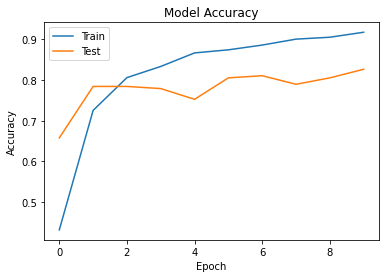

---------------------------------------------------------------------


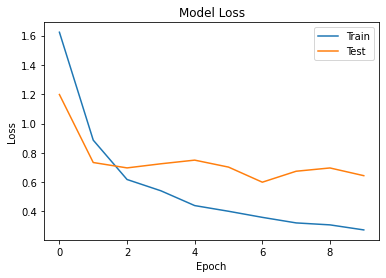

---------------------------------------------------------------------
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_14 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_14 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_14 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 512)         

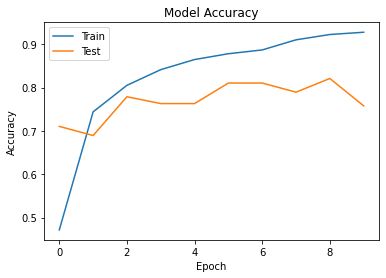

---------------------------------------------------------------------


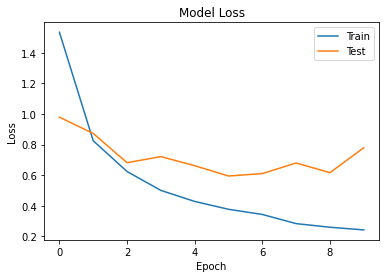

---------------------------------------------------------------------
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_15 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_15 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_15 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer2 (Dense)       (None, 1024)        

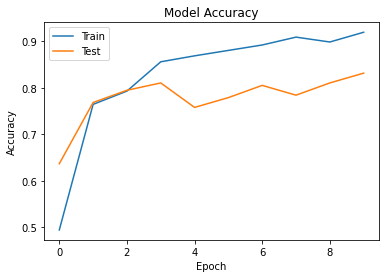

---------------------------------------------------------------------


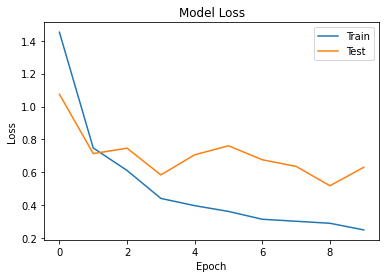

---------------------------------------------------------------------


In [ ]:
# Tune number of neurons
numNeurons = [128, 256, 512, 1024]

for neurons in numNeurons:  
  model = keras.Sequential([
      keras.layers.Rescaling(1. / 127.5, offset = -1),
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.2),
      transfer_layer2,
      keras.layers.Dense(neurons, activation = optimal_activation, name = 'hidden_layer2'),
      keras.layers.Dense(neurons / 2, activation = optimal_activation, name = 'hidden_layer3'),
      keras.layers.Dense(8, activation = 'softmax', name = 'output')
    ])
  
  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
  
  history = model.fit(trainds, epochs = 10, validation_data = validationds)
  
  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

In [ ]:
optimal_neurons = 1024

Best is two dense layers with 1024 and 512 number of neurons

# Iteration B.6 - Tuning Dropout Value with Two Dense Layers

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_16 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_16 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_16 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer (Dense)        (None, 1024)              2098176   
                                                     

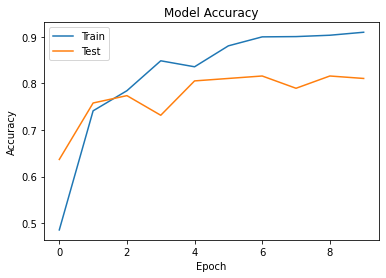

---------------------------------------------------------------------


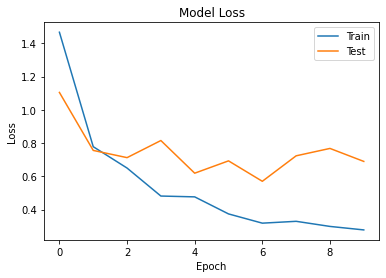

---------------------------------------------------------------------
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_17 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_17 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_17 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer (Dense)        (None, 1024)        

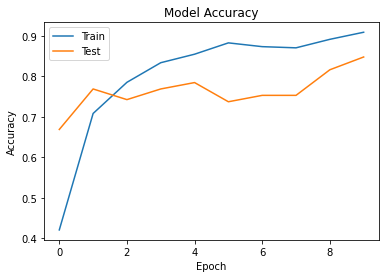

---------------------------------------------------------------------


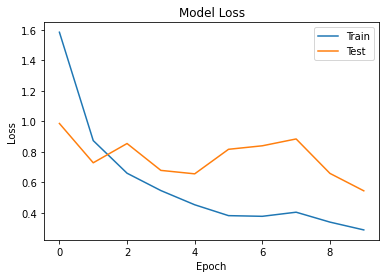

---------------------------------------------------------------------
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_18 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_18 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_18 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer (Dense)        (None, 1024)        

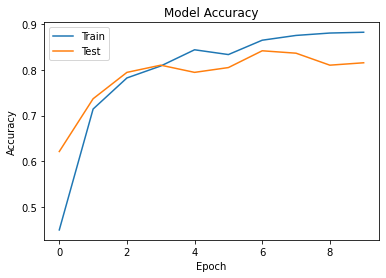

---------------------------------------------------------------------


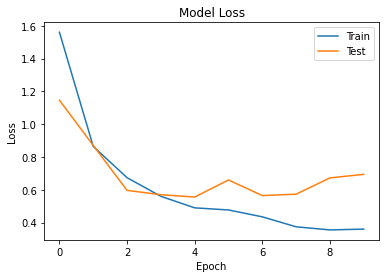

---------------------------------------------------------------------
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_19 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_19 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_19 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer (Dense)        (None, 1024)        

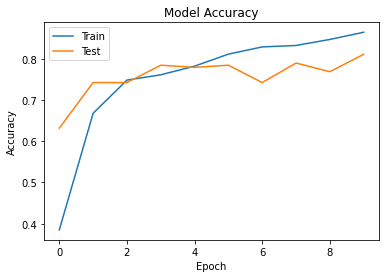

---------------------------------------------------------------------


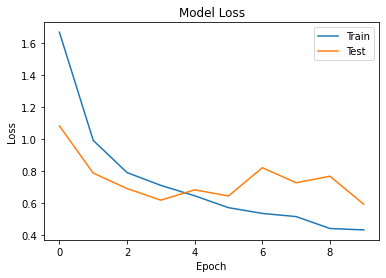

---------------------------------------------------------------------


In [ ]:
# Tune dropout value
dropout_values = [0.1, 0.2, 0.33, 0.5]

for value in dropout_values:  
  model = keras.Sequential([
      keras.layers.Rescaling(1./127.5, offset = -1),
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.2),
      transfer_layer2,
      keras.layers.Dense(optimal_neurons, activation = optimal_activation, name = 'hidden_layer'),
      keras.layers.Dropout(value),
      keras.layers.Dense(optimal_neurons / 2, activation = optimal_activation, name = 'hidden_layer2'),
      keras.layers.Dense(8, activation = 'softmax', name = 'output')
    ])
  
  model.build(input_shape = (None, 224, 224, 3))
  model.summary()

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
  
  history = model.fit(trainds, epochs = 10, validation_data = validationds)

  # Print plots
  print('---------------------------------------------------------------------')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc = 'best')
  plt.show()
  print('---------------------------------------------------------------------')

In [ ]:
optimal_dropout = 0.33

Best is dropout rate of 0.33

# Iteration B.7 - Fine Tuning Using Optimal Hyperparameters

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_20 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_20 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_20 (RandomZoom)  (None, 224, 224, 3)      0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 hidden_layer (Dense)        (None, 1024)              2098176   
                                                     

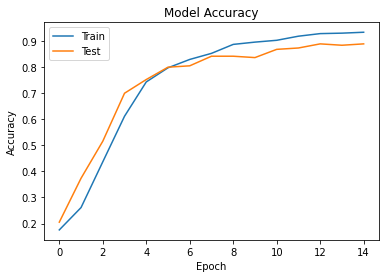

---------------------------------------------------------------------


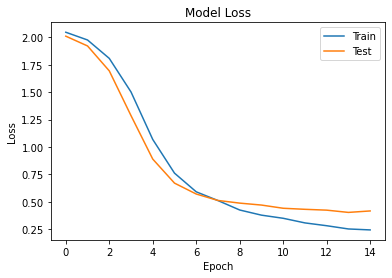

---------------------------------------------------------------------


In [ ]:
# For this convolutional base, we are unable to unfreeze only the top layers, so
# instead we train on the entire convolutional base with a very low learning rate.
transfer_layer2.trainable = True;

model = keras.Sequential([
      keras.layers.Rescaling(1. / 127.5, offset = -1),
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.2),
      transfer_layer2,
      keras.layers.Dense(optimal_neurons, activation = optimal_activation, name = 'hidden_layer'),
      keras.layers.Dropout(optimal_dropout),
      keras.layers.Dense(optimal_neurons / 2, activation = optimal_activation, name = 'hidden_layer2'),
      keras.layers.Dense(8, activation = 'softmax', name = 'output')
    ])

model.build(input_shape = (None, 224,224,3))
model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate = optimal_rate / 100),
              loss = keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(trainds, epochs = 15, validation_data = validationds)

# Print plots
print('---------------------------------------------------------------------')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()
print('---------------------------------------------------------------------')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()
print('---------------------------------------------------------------------')

# Predicting Test Data Points

Best model was the last model–the ResNetV2 fine-tuned model, so we use that to predict test data points.

1/1 [==============================] - 0s 42ms/step


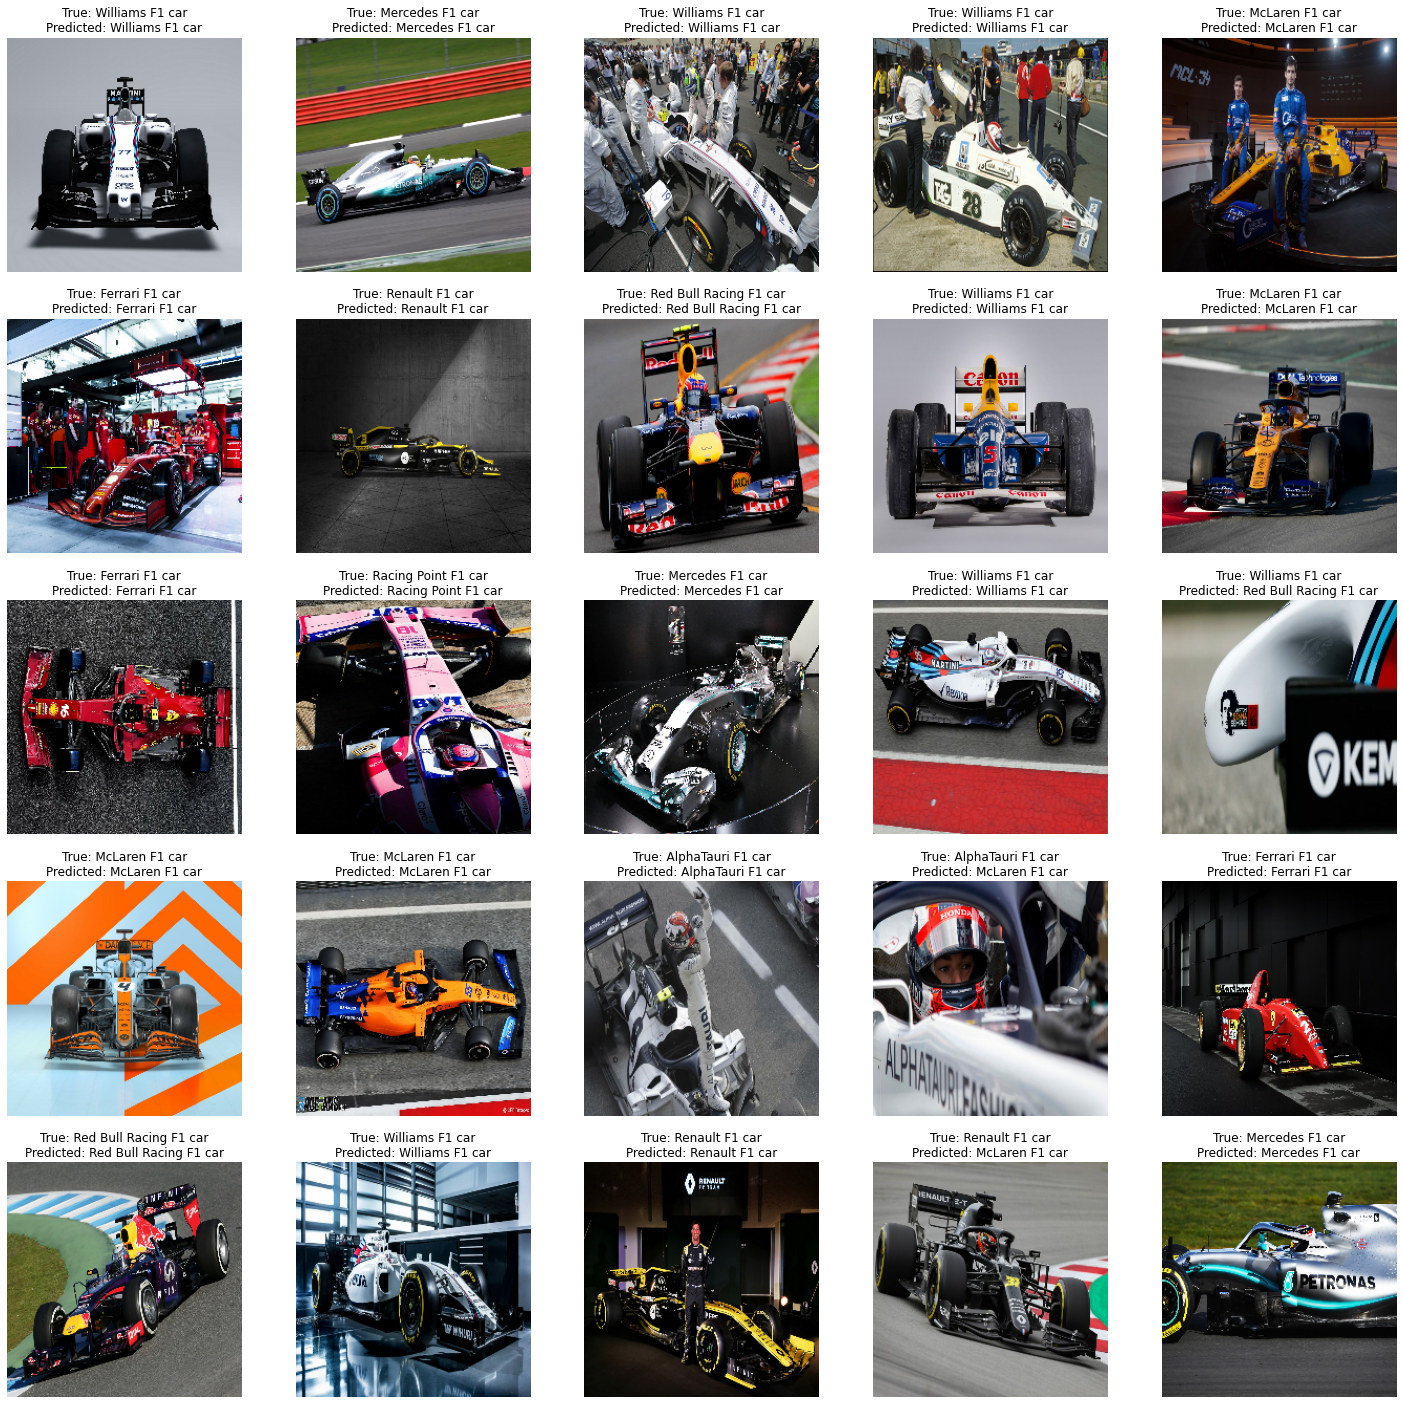

In [ ]:
class_names = display_ds.class_names

plt.figure(figsize=(25, 25))   
for images, labels in validationds.take(1):

  predicted = model.predict(images)

  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predval = np.where(predicted[i] == max(predicted[i]))[0][0]
    actval = np.where(labels[i].numpy() == 1)[0][0]
    label = 'True: {}\nPredicted: {}'.format(class_names[actval], class_names[predval])
    plt.title(label)
    plt.axis("off")